In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import exposure

In [12]:
def show(imgs, titles=None, cmap='gray', figsize=(14,4)):
    if not isinstance(imgs, list):
        imgs = [imgs]
    if titles is None:
        titles = [''] * len(imgs)
    plt.figure(figsize=figsize)
    for i,(im,t) in enumerate(zip(imgs, titles)):
        plt.subplot(1, len(imgs), i+1)
        if len(im.shape)==2:
            plt.imshow(im, cmap=cmap)
        else:
            plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
        plt.title(t)
        plt.axis("off")
    plt.show()

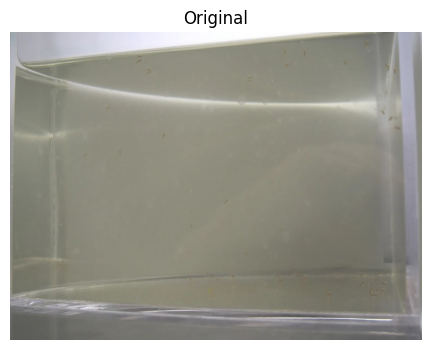

In [13]:
path = "input3.jpg"
img = cv2.imread(path)

if img is None:
    raise FileNotFoundError("Image could not be loaded, check the path!")

show([img], ["Original"])

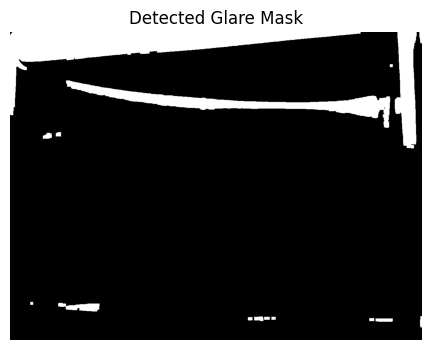

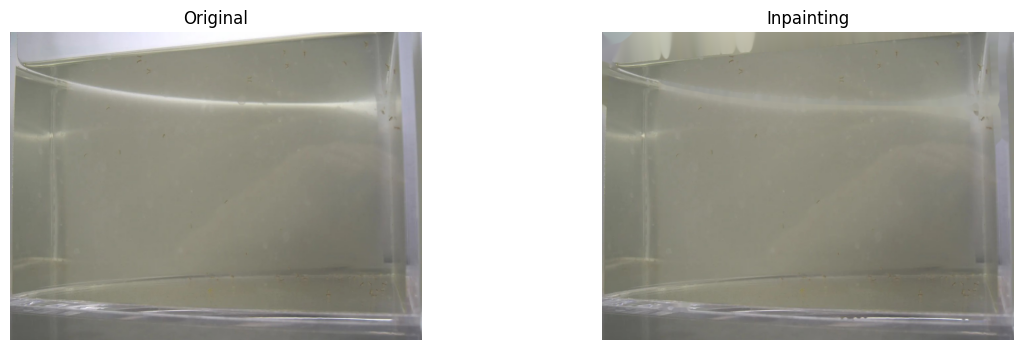

In [38]:
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
h, s, v = cv2.split(hsv)

glare_mask = (v > 170) & (s < 60)
glare_mask = glare_mask.astype(np.uint8) * 255

kernel = np.ones((5,5), np.uint8)
glare_mask = cv2.morphologyEx(glare_mask, cv2.MORPH_OPEN, kernel)
glare_mask = cv2.morphologyEx(glare_mask, cv2.MORPH_DILATE, kernel)

show([glare_mask], ["Detected Glare Mask"], cmap='gray')

inpainted = cv2.inpaint(img, glare_mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)

show([img, inpainted], ["Original", "Inpainting"])

In [33]:
def MSR(img, sigmas=[5, 20, 250]):
    img = img.astype(np.float32) / 255.0
    log_img = np.log1p(img)
    retinex = np.zeros_like(img)
    for s in sigmas:
        blur = cv2.GaussianBlur(img, (0,0), sigmaX=s, sigmaY=s)
        retinex += log_img - np.log1p(blur)
    retinex /= len(sigmas)

    retinex = (retinex - retinex.min()) / (retinex.max() - retinex.min())
    retinex = (retinex * 255).astype(np.uint8)
    return retinex

msr = MSR(img)

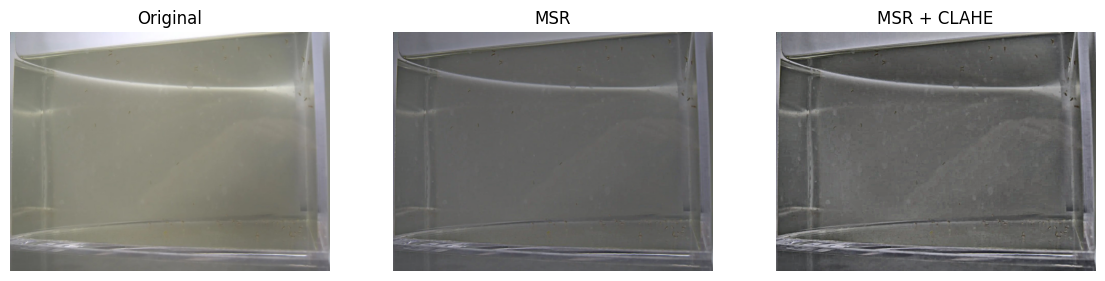

In [34]:
lab = cv2.cvtColor(msr, cv2.COLOR_BGR2LAB)
l,a,b = cv2.split(lab)
l = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8)).apply(l)
msr_clahe = cv2.merge([l,a,b])
msr_clahe = cv2.cvtColor(msr_clahe, cv2.COLOR_LAB2BGR)

show([img, msr, msr_clahe], 
     ["Original", "MSR", 
      "MSR + CLAHE"])